In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
import soundfile as sf
from scipy.io import wavfile

In [11]:
def read_wav_file(file_path):
    """
    Đọc tệp WAV và trả về dữ liệu âm thanh (y) và tốc độ lấy mẫu (fs).
    """
    y, fs = librosa.load(file_path)
    return y, fs

In [12]:
def calculate_ste(y, frame_size=256, hop_size=128):
    """
    Tính toán năng lượng theo thời gian ngắn (STE) của tín hiệu âm thanh.

    Parameters:
        y (numpy.ndarray): Tín hiệu âm thanh.
        frame_size (int): Kích thước của khung.
        hop_size (int): Kích thước của bước nhảy.

    Returns:
        numpy.ndarray: Mảng STE.
    """
    num_frames = len(y) - frame_size + hop_size
    num_frames = num_frames // hop_size
    ste = np.zeros(num_frames)
    
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        ste[i] = np.sum(np.abs(y[start:end]) ** 2)
    
    return ste

In [13]:
def normalize(ste):
    """
    Chuẩn hóa năng lượng theo thời gian ngắn (STE).

    Parameters:
        ste (numpy.ndarray): Mảng STE.

    Returns:
        numpy.ndarray: Mảng STE đã được chuẩn hóa.
    """
    return ste / np.max(ste)

In [14]:
def find_voiced_segments(ste, threshold):
    """
    Tìm các phân đoạn nói dựa trên giá trị STE và ngưỡng tốt nhất.
    """
    starts = []
    ends = []
    start = None
    end = None

    for i in range(len(ste)):
        if ste[i] > threshold:
            if end is None:
                start = i
            end = i + 1
        else:
            if start is not None:
                starts.append(start)
                ends.append(end)
                start = None
                end = None

    return starts, ends

In [15]:
def remove_short_silences(starts, ends, hop_size, fs, min_duration):
    new_starts = []
    new_ends = []
    for start, end in zip(starts, ends):
        duration = (end - start) * hop_size / fs
        if duration >= min_duration:
            new_starts.append(start)
            new_ends.append(end)
    return new_starts, new_ends

In [16]:
def process_ste(y, fs, frame_size, hop_size, best_threshold):
    """
    Xử lý Short-term energy (STE) và loại bỏ các khoảng im lặng ngắn.
    """
    # Tính toán STE
    ste = calculate_ste(y, frame_size, hop_size)
    ste = normalize(ste)
    
    # Tìm các đoạn có giọng nói
    starts, ends = find_voiced_segments(ste, best_threshold)
    
    # Loại bỏ các khoảng im lặng ngắn
    starts, ends = remove_short_silences(starts, ends, hop_size, fs, 0.3)
    # Vẽ biểu đồ STE theo thời gian
    plt.figure(figsize=(10, 4))
    times = np.arange(len(ste)) * hop_size / fs
    plt.plot(times, ste, label='Năng lượng ngắn hạn')
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Năng lượng')
    plt.title('Năng lượng ngắn hạn (STE) theo thời gian')
    plt.grid(True)
    plt.legend()
    plt.show()

    return ste, starts, ends

In [17]:
def process_audio_file(file_path, frame_size=256, hop_size=128, best_threshold=0.0002, min_segment_duration=1.0):
    # Load the audio file
    y, fs = librosa.load(file_path)

    # Calculate STE and remove short silent segments
    ste, starts, ends = process_ste(y, fs, frame_size, hop_size, best_threshold)

    audio_segments = []

    print(y, fs)

    for i in range(len(starts)):
        segment_duration = ends[i] - starts[i]
        duration = (ends[i] - starts[i]) * hop_size / fs
        if duration >= min_segment_duration and duration <= 10.0:
            audio_segment = y[int(starts[i] * hop_size):int(ends[i] * hop_size)]
            
            # Save the audio segment as a WAV file
            output_file = f"D:/data_analysis/speech_emotion_recognition/audio_test/Bong_Dung_Muon_Khoc/divide_segment/1/segment_{i}_2.wav"
            sf.write(output_file, audio_segment, fs)

            audio_segments.append(audio_segment)

    return audio_segments

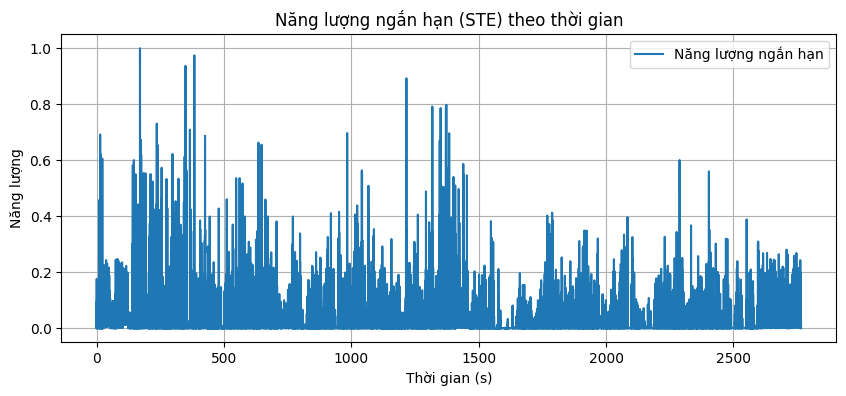

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.8009041e-07
 -1.5521346e-07  1.3039653e-07] 22050


[array([ 2.6126206e-04,  2.2694282e-04,  1.7900020e-05, ...,
        -6.7241946e-03, -4.3110605e-03, -9.0958131e-03], dtype=float32),
 array([-0.00903918, -0.01077789, -0.00927001, ..., -0.0208328 ,
        -0.01975569, -0.01810278], dtype=float32),
 array([-0.01497812, -0.01588999, -0.01765396, ...,  0.00239037,
         0.00233268,  0.00217731], dtype=float32),
 array([-1.9545704e-03,  2.6796013e-04, -5.6922436e-05, ...,
         1.5831532e-02,  1.6399615e-02,  1.6694091e-02], dtype=float32),
 array([-0.00295596,  0.00341003,  0.00357878, ...,  0.02136744,
         0.02511868,  0.02565589], dtype=float32),
 array([-0.00699829, -0.00216394, -0.0027773 , ..., -0.01771157,
        -0.01119882, -0.01495454], dtype=float32),
 array([0.00265537, 0.00187209, 0.00475452, ..., 0.0019058 , 0.01192091,
        0.00719991], dtype=float32),
 array([ 0.00124219,  0.00844336,  0.00345592, ..., -0.02920686,
        -0.01985298, -0.0080201 ], dtype=float32),
 array([-0.00377909, -0.00405422, -0.00423

In [18]:
process_audio_file(r"D:\data_analysis\speech_emotion_recognition\audio_test\Bong_Dung_Muon_Khoc\raw\2.wav")